In [266]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


import pickle

from tqdm import tqdm
import os




In [267]:
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [268]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [269]:
data  = pd.read_csv('preprocessed_data.csv', nrows=50000)
data.head(5)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [270]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
X.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05


In [271]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

In [272]:
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
x_train_essay_bow = vectorizer.transform(X_train['essay'].values)
x_cv_essay_bow = vectorizer.transform(X_cv['essay'].values)
x_test_essay_bow = vectorizer.transform(X_test['essay'].values)

print("After vectorizations")
print(x_train_essay_bow.shape, y_train.shape)
print(x_cv_essay_bow.shape, y_cv.shape)
print(x_test_essay_bow.shape, y_test.shape)
print("="*100)

(22445, 8) (22445,)
(11055, 8) (11055,)
(16500, 8) (16500,)
After vectorizations
(22445, 5000) (22445,)
(11055, 5000) (11055,)
(16500, 5000) (16500,)


In [273]:
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
x_train_essay_tfidf = vectorizer.transform(X_train['essay'].values)
x_cv_essay_tfidf = vectorizer.transform(X_cv['essay'].values)
x_test_essay_tfidf = vectorizer.transform(X_test['essay'].values)

print("After vectorizations")
print(x_train_essay_tfidf.shape, y_train.shape)
print(x_cv_essay_tfidf.shape, y_cv.shape)
print(x_test_essay_tfidf.shape, y_test.shape)
print("="*100)

(22445, 8) (22445,)
(11055, 8) (11055,)
(16500, 8) (16500,)
After vectorizations
(22445, 5000) (22445,)
(11055, 5000) (11055,)
(16500, 5000) (16500,)


In [274]:
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
model = loadGloveModel('glove.42B.300d.txt')


Loading Glove Model


1917495it [10:43, 2980.81it/s]


Done. 1917495  words loaded!


In [275]:
words = []
data_essay=data['essay']
for i in data_essay:
    words.extend(i.split(' '))

#for i in preproced_titles:
#    words.extend(i.split(' '))
print("all the words in the coupus", len(words))
words = set(words)
print("the unique words in the coupus", len(words))

inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our coupus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

words_courpus = {}
words_glove = set(model.keys())
for i in words:
    if i in words_glove:
        words_courpus[i] = model[i]
print("word 2 vec length", len(words_courpus))


# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_courpus, f)

all the words in the coupus 7639920
the unique words in the coupus 41242
The number of words that are present in both glove vectors and our coupus 37756 ( 91.547 %)
word 2 vec length 37756


In [276]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [277]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_X_train_essay = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm( X_train['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_X_train_essay.append(vector)

print(len(avg_w2v_vectors_X_train_essay))
print(len(avg_w2v_vectors_X_train_essay[0]))

100%|██████████████████████████████████| 22445/22445 [00:11<00:00, 1971.82it/s]


22445
300


In [278]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_X_test_essay = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_X_test_essay.append(vector)

print(len(avg_w2v_vectors_X_test_essay))
print(len(avg_w2v_vectors_X_test_essay[0]))

100%|██████████████████████████████████| 16500/16500 [00:07<00:00, 2073.49it/s]


16500
300


In [279]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_X_cv_essay = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_X_cv_essay.append(vector)

print(len(avg_w2v_vectors_X_cv_essay))
print(len(avg_w2v_vectors_X_cv_essay[0]))

100%|██████████████████████████████████| 11055/11055 [00:05<00:00, 1969.58it/s]


11055
300


In [280]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['essay'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [281]:
tfidf_w2v_vectors_X_train_essay = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_X_train_essay.append(vector)

print(len(tfidf_w2v_vectors_X_train_essay))
print(len(tfidf_w2v_vectors_X_train_essay[0]))

100%|███████████████████████████████████| 22445/22445 [01:28<00:00, 252.95it/s]


22445
300


In [282]:
tfidf_w2v_vectors_X_test_essay = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_X_test_essay.append(vector)

print(len(tfidf_w2v_vectors_X_test_essay))
print(len(tfidf_w2v_vectors_X_test_essay[0]))

100%|███████████████████████████████████| 16500/16500 [01:05<00:00, 251.90it/s]


16500
300


In [283]:
tfidf_w2v_vectors_X_cv_essay = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_X_cv_essay.append(vector)

print(len(tfidf_w2v_vectors_X_cv_essay))
print(len(tfidf_w2v_vectors_X_cv_essay[0]))

100%|███████████████████████████████████| 11055/11055 [00:44<00:00, 248.18it/s]


11055
300


In [284]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

In [285]:
ex = ["classroom students should take break",
"low income homes students receive free breakfast",
"students will receive low grades"]
vectorizer = CountVectorizer()
vectorizer.fit(ex)
print(vectorizer.transform(ex).toarray())
print(vectorizer.get_feature_names())

[[1 0 1 0 0 0 0 0 0 1 1 1 0]
 [0 1 0 1 0 1 1 1 1 0 1 0 0]
 [0 0 0 0 1 0 0 1 1 0 1 0 1]]
['break', 'breakfast', 'classroom', 'free', 'grades', 'homes', 'income', 'low', 'receive', 'should', 'students', 'take', 'will']


In [286]:
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=20000)
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data


(22445, 8) (22445,)
(11055, 8) (11055,)
(16500, 8) (16500,)


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=20000, min_df=10,
        ngram_range=(1, 4), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [287]:
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=20000)
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data

(22445, 8) (22445,)
(11055, 8) (11055,)
(16500, 8) (16500,)


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=20000, min_df=10,
        ngram_range=(1, 4), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [288]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
x_train_state_ohe = vectorizer.transform(X_train['school_state'].values)
x_cv_state_ohe = vectorizer.transform(X_cv['school_state'].values)
x_test_state_ohe = vectorizer.transform(X_test['school_state'].values)

print("After vectorizations")
print(x_train_state_ohe.shape, y_train.shape)
print(x_cv_state_ohe.shape, y_cv.shape)
print(x_test_state_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(22445, 51) (22445,)
(11055, 51) (11055,)
(16500, 51) (16500,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


In [289]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
x_train_teacher_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
x_cv_teacher_ohe = vectorizer.transform(X_cv['teacher_prefix'].values)
x_test_teacher_ohe = vectorizer.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(x_train_teacher_ohe.shape, y_train.shape)
print(x_cv_teacher_ohe.shape, y_cv.shape)
print(x_test_teacher_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(22445, 5) (22445,)
(11055, 5) (11055,)
(16500, 5) (16500,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


In [290]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
x_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)
x_cv_grade_ohe = vectorizer.transform(X_cv['project_grade_category'].values)
x_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(x_train_grade_ohe.shape, y_train.shape)
print(x_cv_grade_ohe.shape, y_cv.shape)
print(x_test_grade_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(22445, 4) (22445,)
(11055, 4) (11055,)
(16500, 4) (16500,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


In [291]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['price'].values.reshape(1,-1))

x_train_price_norm = normalizer.transform(X_train['price'].values.reshape(1,-1)).reshape(-1,1)
x_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(1,-1)).reshape(-1,1)
x_test_price_norm = normalizer.transform(X_test['price'].values.reshape(1,-1)).reshape(-1,1)

print("After vectorizations")
print(x_train_price_norm.shape, y_train.shape)
print(x_cv_price_norm.shape, y_cv.shape)
print(x_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


In [292]:
from scipy.sparse import hstack
x_tr1 = hstack((x_train_state_ohe,x_train_teacher_ohe,x_train_grade_ohe,x_train_price_norm,x_train_essay_bow)).tocsr()
x_cv1 = hstack((x_cv_state_ohe,x_cv_teacher_ohe,x_cv_grade_ohe,x_cv_price_norm,x_cv_essay_bow)).tocsr()
x_te1 = hstack((x_test_state_ohe,x_test_teacher_ohe,x_test_grade_ohe,x_test_price_norm,x_test_essay_bow)).tocsr()

print("Final Data matrix")
print(x_tr1.shape, y_train.shape)
print(x_cv1.shape, y_cv.shape)
print(x_te1.shape, y_test.shape)
print("="*100)

Final Data matrix
(22445, 5061) (22445,)
(11055, 5061) (11055,)
(16500, 5061) (16500,)


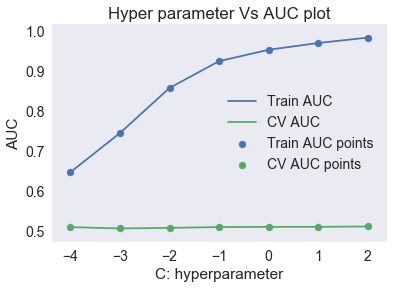

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.957839,0.066402,0.508821,0.646055,0.0001,{'C': 0.0001},5,0.508023,0.641992,0.511958,0.651757,0.506481,0.644418,0.902415,8.258253e-02,0.002306,0.004152
1,0.597169,0.018663,0.505387,0.744025,0.001,{'C': 0.001},7,0.507590,0.741734,0.509351,0.743455,0.499221,0.746886,0.013380,2.015689e-02,0.004419,0.002141
2,1.221740,0.008007,0.506953,0.856635,0.01,{'C': 0.01},6,0.508256,0.854780,0.514648,0.855555,0.497953,0.859570,0.013890,3.371748e-07,0.006878,0.002099
3,2.959506,0.008008,0.508906,0.923675,0.1,{'C': 0.1},4,0.513611,0.921868,0.516613,0.921481,0.496494,0.927676,0.018643,3.371748e-07,0.008861,0.002833
4,6.703553,0.008674,0.509454,0.952107,1,{'C': 1},2,0.515940,0.950609,0.516411,0.949610,0.496010,0.956101,0.364528,4.715977e-04,0.009508,0.002854


In [293]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint as sp_randint

lr=LogisticRegression(class_weight='balanced')
C = [0.0001,0.001,0.01,0.1,1,10, 100]
params = {'C':[0.0001,0.001,0.01,0.1,1,10, 100]}
clf = GridSearchCV(lr,param_grid = params, cv = 3,  scoring='roc_auc')
clf.fit(x_tr1, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_C'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
C_values =  results['param_C']

plt.plot(np.log10(C), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log10(C), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(np.log10(C), train_auc, label='Train AUC points')
plt.scatter(np.log10(C), cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results.head()

In [294]:
def batch_predict(clf, data):    
    y_data_pred = []    
    tr_loop = data.shape[0] - data.shape[0]%1000
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
                                                                
    return y_data_pred                       


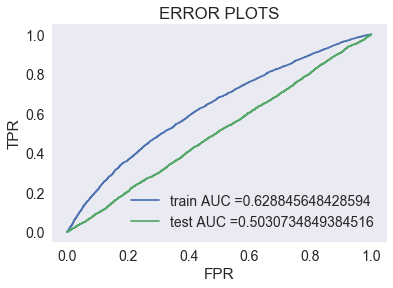

In [295]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
best_C=0.0001
lr = LogisticRegression(penalty = 'l2', C = best_C, random_state = 0,class_weight='balanced')
lr.fit(x_tr1, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(lr, x_tr1)    
y_test_pred = batch_predict(lr, x_te1)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [296]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [297]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.3532138285195693 for threshold 0.5
Train confusion matrix
[[ 2100  1495]
 [ 7452 11398]]
Test confusion matrix
[[1130 1512]
 [5906 7952]]


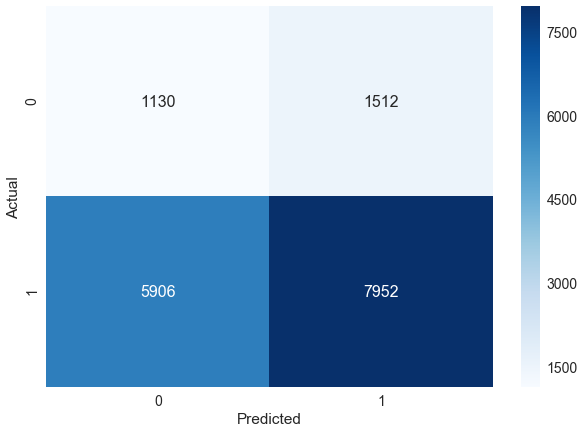

In [298]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
data = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16},fmt='g')# font size

In [299]:
from scipy.sparse import hstack
x_tr2 = hstack((x_train_state_ohe,x_train_teacher_ohe,x_train_grade_ohe,x_train_price_norm,x_train_essay_tfidf)).tocsr()
x_cv2 = hstack((x_cv_state_ohe,x_cv_teacher_ohe,x_cv_grade_ohe,x_cv_price_norm,x_cv_essay_tfidf)).tocsr()
x_te2 = hstack((x_test_state_ohe,x_test_teacher_ohe,x_test_grade_ohe,x_test_price_norm,x_test_essay_tfidf)).tocsr()

print("Final Data matrix")
print(x_tr2.shape, y_train.shape)
print(x_cv2.shape, y_cv.shape)
print(x_te2.shape, y_test.shape)
print("="*100)

Final Data matrix
(22445, 5061) (22445,)
(11055, 5061) (11055,)
(16500, 5061) (16500,)


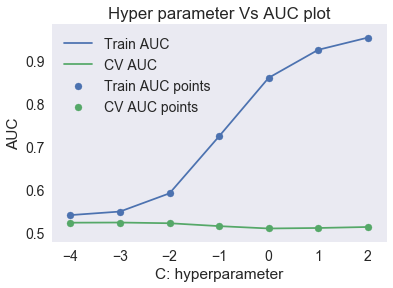

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.219007,0.008008,0.523542,0.541120,0.0001,{'C': 0.0001},2,0.528184,0.542899,0.515228,0.543053,0.527212,0.537407,0.048590,4.052337e-07,0.005891,0.002626
1,0.322642,0.008007,0.523905,0.549299,0.001,{'C': 0.001},1,0.527025,0.552444,0.515738,0.551554,0.528952,0.543900,0.009683,4.052337e-07,0.005828,0.003835
2,0.489803,0.008341,0.522234,0.591594,0.01,{'C': 0.01},3,0.522469,0.593142,0.515048,0.592300,0.529186,0.589339,0.030670,4.721009e-04,0.005774,0.001631
3,0.947243,0.008674,0.515535,0.723797,0.1,{'C': 0.1},4,0.517698,0.721262,0.512588,0.719357,0.516319,0.730773,0.020874,4.715952e-04,0.002159,0.004993
4,1.815681,0.008008,0.510094,0.859322,1,{'C': 1},7,0.512249,0.856480,0.514808,0.856894,0.503223,0.864592,0.060942,2.247832e-07,0.004969,0.003730


In [300]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint as sp_randint

lr=LogisticRegression(class_weight='balanced')
C=[0.0001,0.001,0.01,0.1,1,10,100]
params = {'C':[0.0001,0.001,0.01,0.1,1,10,100]}
clf = GridSearchCV(lr,param_grid = params, cv = 3,  scoring='roc_auc')
clf.fit(x_tr2, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_C'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
C_values =  results['param_C']

plt.plot(np.log10(C), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log10(C), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(np.log10(C), train_auc, label='Train AUC points')
plt.scatter(np.log10(C), cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results.head()

In [301]:
def batch_predict(clf, data):    
    y_data_pred = []    
    tr_loop = data.shape[0] - data.shape[0]%1000
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
                                                                
    return y_data_pred                       


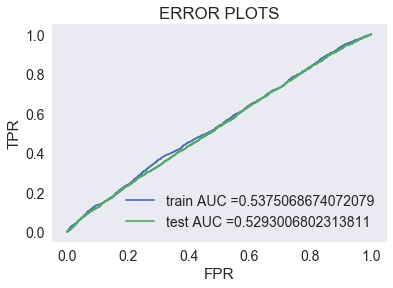

In [302]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression

best_C=0.0001
lr = LogisticRegression(penalty = 'l2', C = best_C, random_state = 0,class_weight='balanced')
lr.fit(x_tr2, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(lr, x_tr2)    
y_test_pred = batch_predict(lr, x_te2)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [303]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [304]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

Train confusion matrix
[[ 1765  1830]
 [ 8604 10246]]
the maximum value of tpr*(1-fpr) 0.2731399268804669 for threshold 0.502
Test confusion matrix
[[1520 1122]
 [7527 6331]]


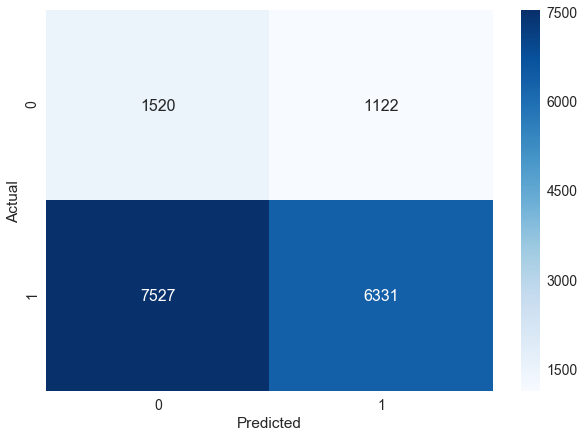

In [305]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
data = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16},fmt='g')# font size

In [306]:
from scipy.sparse import hstack
x_tr3 = hstack((x_train_state_ohe,x_train_teacher_ohe,x_train_grade_ohe,x_train_price_norm,avg_w2v_vectors_X_train_essay)).tocsr()
x_cv3 = hstack((x_cv_state_ohe,x_cv_teacher_ohe,x_cv_grade_ohe,x_cv_price_norm,avg_w2v_vectors_X_cv_essay)).tocsr()
x_te3 = hstack((x_test_state_ohe,x_test_teacher_ohe,x_test_grade_ohe,x_test_price_norm,avg_w2v_vectors_X_test_essay)).tocsr()

print("Final Data matrix")
print(x_tr3.shape, y_train.shape)
print(x_cv3.shape, y_cv.shape)
print(x_te3.shape, y_test.shape)
print("="*100)

Final Data matrix
(22445, 361) (22445,)
(11055, 361) (11055,)
(16500, 361) (16500,)


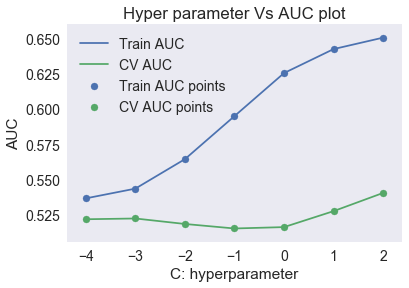

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.412036,0.012679,0.521948,0.536732,0.0001,{'C': 0.0001},4,0.525490,0.539224,0.513338,0.538921,0.527015,0.532051,0.042659,4.718761e-04,0.006119,0.003313
1,0.485476,0.012012,0.522488,0.543623,0.001,{'C': 0.001},3,0.524128,0.546772,0.514109,0.546297,0.529228,0.537801,0.001633,2.247832e-07,0.006280,0.004122
2,0.796106,0.012012,0.518606,0.564485,0.01,{'C': 0.01},5,0.515871,0.568796,0.510442,0.567287,0.529505,0.557371,0.045802,3.371748e-07,0.008019,0.005068
3,1.681951,0.012012,0.515415,0.594957,0.1,{'C': 0.1},7,0.512291,0.598601,0.510255,0.596838,0.523701,0.589432,0.011630,2.247832e-07,0.005917,0.003972
4,3.380576,0.012345,0.516389,0.625421,1,{'C': 1},6,0.515527,0.627611,0.512907,0.627080,0.520732,0.621572,0.043739,4.721573e-04,0.003252,0.002730


In [307]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint as sp_randint

lr=LogisticRegression(class_weight='balanced')
C=[0.0001,0.001,0.01,0.1,1,10,100]
params = {'C':[0.0001,0.001,0.01,0.1,1,10,100]}
clf = GridSearchCV(lr,param_grid = params, cv = 3,  scoring='roc_auc')
clf.fit(x_tr3, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_C'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
C_values =  results['param_C']

plt.plot(np.log10(C), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log10(C), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(np.log10(C), train_auc, label='Train AUC points')
plt.scatter(np.log10(C), cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results.head()

In [308]:
def batch_predict(clf, data):    
    y_data_pred = []    
    tr_loop = data.shape[0] - data.shape[0]%1000
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
                                                                
    return y_data_pred                       


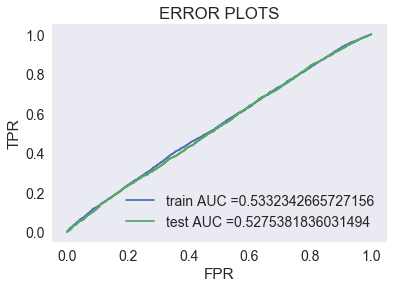

In [309]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression

best_C=0.0001
lr = LogisticRegression(penalty = 'l2', C = best_C, random_state = 0,class_weight='balanced')
lr.fit(x_tr3, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(lr, x_tr3)    
y_test_pred = batch_predict(lr, x_te3)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [310]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [311]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

Train confusion matrix
[[ 2359  1236]
 [11462  7388]]
the maximum value of tpr*(1-fpr) 0.2700446021773536 for threshold 0.502
Test confusion matrix
[[1505 1137]
 [7479 6379]]


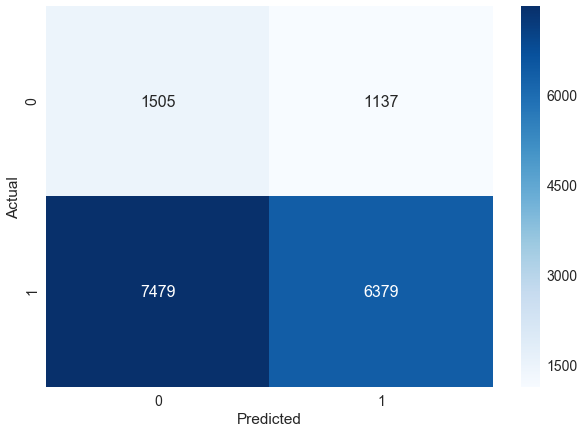

In [312]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
data = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16},fmt='g')# font size

In [321]:
x_tr4 = hstack((x_train_state_ohe,x_train_teacher_ohe,x_train_grade_ohe,x_train_price_norm,tfidf_w2v_vectors_X_train_essay)).tocsr()
x_cv4 = hstack((x_cv_state_ohe,x_cv_teacher_ohe,x_cv_grade_ohe,x_cv_price_norm,np.array(tfidf_w2v_vectors_X_cv_essay))).tocsr()
x_te4 = hstack((x_test_state_ohe,x_test_teacher_ohe,x_test_grade_ohe,x_test_price_norm,tfidf_w2v_vectors_X_test_essay)).tocsr()

print("Final Data matrix")
print(x_tr4.shape, y_train.shape)
print(x_cv4.shape, y_cv.shape)
print(x_te4.shape, y_test.shape)
print("="*100)

Final Data matrix
(22445, 361) (22445,)
(11055, 361) (11055,)
(16500, 361) (16500,)


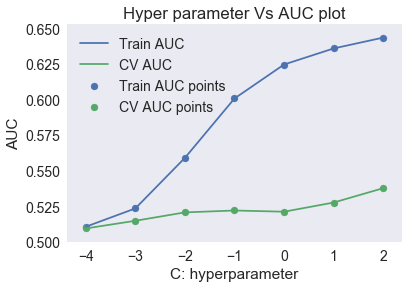

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.342452,0.013217,0.509392,0.510589,0.0001,{'C': 0.0001},7,0.494786,0.517833,0.531137,0.499975,0.502255,0.513959,0.003395,0.001704,0.015675,0.007670
1,0.377493,0.014421,0.514786,0.523467,0.001,{'C': 0.001},6,0.502325,0.529692,0.532052,0.516024,0.509985,0.524684,0.003456,0.001704,0.012602,0.005646
2,0.687550,0.010417,0.520664,0.558980,0.01,{'C': 0.01},5,0.513024,0.563183,0.526051,0.557560,0.522920,0.556197,0.000008,0.007366,0.005553,0.003024
3,1.178659,0.014420,0.522001,0.600675,0.1,{'C': 0.1},3,0.518244,0.603293,0.523210,0.600277,0.524552,0.598454,0.032402,0.001704,0.002713,0.001996
4,2.396083,0.005207,0.521146,0.624533,1,{'C': 1},4,0.521228,0.626418,0.521908,0.623578,0.520301,0.623603,0.042834,0.007364,0.000658,0.001333


In [322]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint as sp_randint

lr=LogisticRegression()
C=[0.0001,0.001,0.01,0.1,1,10,100]
params = {'C':[0.0001,0.001,0.01,0.1,1,10,100]}
clf = GridSearchCV(lr,param_grid = params, cv = 3,  scoring='roc_auc')
clf.fit(x_tr4, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_C'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
C_values =  results['param_C']

plt.plot(np.log10(C), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log10(C), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(np.log10(C), train_auc, label='Train AUC points')
plt.scatter(np.log10(C), cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results.head()

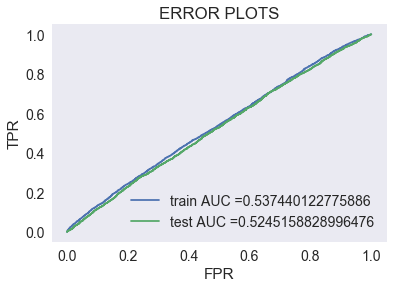

In [323]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression

best_C=0.0001
lr = LogisticRegression(penalty = 'l2', C = best_C, random_state = 0,class_weight='balanced')
lr.fit(x_tr4, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(lr, x_tr4)    
y_test_pred = batch_predict(lr, x_te4)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [324]:
def batch_predict(clf, data):    
    y_data_pred = []    
    tr_loop = data.shape[0] - data.shape[0]%1000
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
                                                                
    return y_data_pred                       


In [325]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

Train confusion matrix
[[ 2093  1502]
 [10048  8802]]
the maximum value of tpr*(1-fpr) 0.2732197902332668 for threshold 0.501
Test confusion matrix
[[1468 1174]
 [7258 6600]]


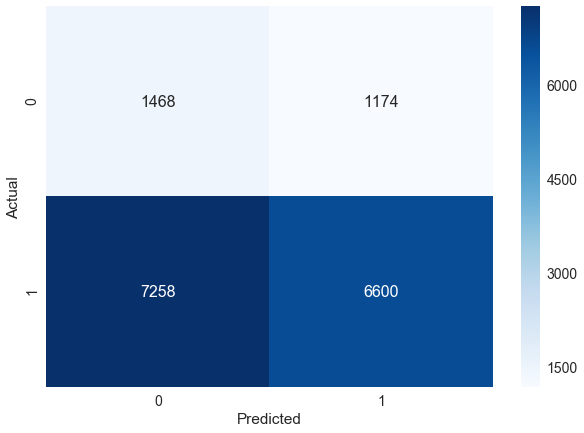

In [326]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
data = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16},fmt='g')# font size

In [327]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

import nltk
nltk.download('vader_lexicon')
sentiment_neg=[] 
sentiment_neu=[] 
sentiment_pos=[]
sentiment_comp=[] 
sid = SIA() # tqdm is for printing the status bar
for sentence in tqdm(X_train['essay'].values):
     es1=sid.polarity_scores(sentence) 
     sentiment_neg.append(es1['neg'])
     sentiment_neu.append(es1['neu'])
     sentiment_pos.append(es1['pos']) 
     sentiment_comp.append(es1['compound'])   
print(es1)        
    

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\LENOVVO\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


100%|███████████████████████████████████| 22445/22445 [01:23<00:00, 268.12it/s]


{'neg': 0.0, 'neu': 0.657, 'pos': 0.343, 'compound': 0.9917}


In [328]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

import nltk
nltk.download('vader_lexicon')
sentiment_neg=[] 
sentiment_neu=[] 
sentiment_pos=[]
sentiment_comp=[] 
sid = SIA() # tqdm is for printing the status bar
for sentence in tqdm(X_test['essay'].values):
     es2=sid.polarity_scores(sentence) 
     sentiment_neg.append(es2['neg'])
     sentiment_neu.append(es2['neu'])
     sentiment_pos.append(es2['pos']) 
     sentiment_comp.append(es2['compound'])   
print(es2)        
    

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\LENOVVO\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


100%|███████████████████████████████████| 16500/16500 [00:59<00:00, 278.77it/s]


{'neg': 0.0, 'neu': 0.806, 'pos': 0.194, 'compound': 0.9712}


In [329]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

import nltk
nltk.download('vader_lexicon')
sentiment_neg=[] 
sentiment_neu=[] 
sentiment_pos=[]
sentiment_comp=[] 
sid = SIA() # tqdm is for printing the status bar
for sentence in tqdm(X_cv['essay'].values):
     es3=sid.polarity_scores(sentence) 
     sentiment_neg.append(es3['neg'])
     sentiment_neu.append(es3['neu'])
     sentiment_pos.append(es3['pos']) 
     sentiment_comp.append(es3['compound'])   
print(es3)        
    

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\LENOVVO\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


100%|███████████████████████████████████| 11055/11055 [00:38<00:00, 284.48it/s]


{'neg': 0.062, 'neu': 0.678, 'pos': 0.26, 'compound': 0.9951}


In [330]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [331]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


In [332]:
project_data.head(2)


,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,5/12/2016 13:43,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,25-10-2016 09:22,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1


In [333]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [334]:
# printing some random essays.
print(project_data['essay'].values[0])
print("="*50)
print(project_data['essay'].values[150])
print("="*50)
print(project_data['essay'].values[1000])
print("="*50)
print(project_data['essay'].values[20000])
print("="*50)
print(project_data['essay'].values[99999])
print("="*50)


My students are English learners that are working on English as their second or third languages. We are a melting pot of refugees, immigrants, and native-born Americans bringing the gift of language to our school. \r\n\r\n We have over 24 languages represented in our English Learner program with students at every level of mastery.  We also have over 40 countries represented with the families within our school.  Each student brings a wealth of knowledge and experiences to us that open our eyes to new cultures, beliefs, and respect.\"The limits of your language are the limits of your world.\"-Ludwig Wittgenstein  Our English learner's have a strong support system at home that begs for more resources.  Many times our parents are learning to read and speak English along side of their children.  Sometimes this creates barriers for parents to be able to help their child learn phonetics, letter recognition, and other reading skills.\r\n\r\nBy providing these dvd's and players, students are ab

The mediocre teacher tells. The good teacher explains. The superior teacher demonstrates. The great teacher inspires. -William A. Ward\r\n\r\nMy school has 803 students which is makeup is 97.6% African-American, making up the largest segment of the student body. A typical school in Dallas is made up of 23.2% African-American students. Most of the students are on free or reduced lunch. We aren't receiving doctors, lawyers, or engineers children from rich backgrounds or neighborhoods. As an educator I am inspiring minds of young children and we focus not only on academics but one smart, effective, efficient, and disciplined students with good character.In our classroom we can utilize the Bluetooth for swift transitions during class. I use a speaker which doesn't amplify the sound enough to receive the message. Due to the volume of my speaker my students can't hear videos or books clearly and it isn't making the lessons as meaningful. But with the bluetooth speaker my students will be abl

In [335]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [336]:
sent = decontracted(project_data['essay'].values[20000])
print(sent)
print("="*50)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations. \r\n\r\nThe materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills. \r\nThey also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing

In [337]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations.     The materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills.   They also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing. Phys

In [338]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays cognitive delays gross fine motor delays to autism They are eager beavers and always strive to work their hardest working past their limitations The materials we have are the ones I seek out for my students I teach in a Title I school where most of the students receive free or reduced price lunch Despite their disabilities and limitations my students love coming to school and come eager to learn and explore Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting This is how my kids feel all the time The want to be able to move as they learn or so they say Wobble chairs are the answer and I love then because they develop their core which enhances gross motor and in Turn fine motor skills They also want to learn through games my kids do not want to sit and do worksheets They want to learn to count by jumping and playing Physical engagement is the

In [339]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [340]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|████████████████████████████████| 109248/109248 [01:48<00:00, 1003.64it/s]


In [341]:
# after preprocesing
preprocessed_essays[20000]

'my kindergarten students varied disabilities ranging speech language delays cognitive delays gross fine motor delays autism they eager beavers always strive work hardest working past limitations the materials ones i seek students i teach title i school students receive free reduced price lunch despite disabilities limitations students love coming school come eager learn explore have ever felt like ants pants needed groove move meeting this kids feel time the want able move learn say wobble chairs answer i love develop core enhances gross motor turn fine motor skills they also want learn games kids not want sit worksheets they want learn count jumping playing physical engagement key success the number toss color shape mats make happen my students forget work fun 6 year old deserves nannan'

In [342]:
# printing some random essays.
print(project_data['project_title'].values[0])
print("="*50)
print(project_data['project_title'].values[150])
print("="*50)
print(project_data['project_title'].values[1000])
print("="*50)


Educational Support for English Learners at Home
More Movement with Hokki Stools
Sailing Into a Super 4th Grade Year


In [343]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [344]:
sent = decontracted(project_data['project_title'].values[20000])
print(sent)
print("="*50)

We Need To Move It While We Input It!


In [345]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

We Need To Move It While We Input It!


In [346]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

We Need To Move It While We Input It 


In [347]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [348]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_title = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_title.append(sent.lower().strip())

100%|███████████████████████████████| 109248/109248 [00:06<00:00, 17053.71it/s]


In [349]:
# after preprocesing
preprocessed_title[20000]

'we need to move it while we input it'

In [350]:
project_data.head(5)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,essay
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,5/12/2016 13:43,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,My students are English learners that are work...
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,25-10-2016 09:22,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,Our students arrive to our school eager to lea...
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,31-08-2016 12:03,Grades 6-8,Health & Sports,"Health & Wellness, Team Sports",Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0,"\r\n\""True champions aren't always the ones th..."
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,6/10/2016 21:16,Grades PreK-2,"Literacy & Language, Math & Science","Literacy, Mathematics",Techie Kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,My students need to engage in Reading and Math...,4,1,I work at a unique school filled with both ESL...
4,172407,p104768,be1f7507a41f8479dc06f047086a39ec,Mrs.,TX,11/7/2016 1:10,Grades PreK-2,Math & Science,Mathematics,Interactive Math Tools,Our second grade classroom next year will be m...,"For many students, math is a subject that does...",NaN,NaN,My students need hands on practice in mathemat...,1,1,Our second grade classroom next year will be m...


In [351]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [352]:
quantity_data = resource_data.groupby('id').agg({'quantity':'price', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, quantity_data, on='id', how='left')

In [353]:
project_data.teacher_prefix = project_data.teacher_prefix.replace(to_replace=np.nan, value="Mrs.")

In [354]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())

In [355]:
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)


In [356]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

In [357]:
project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)


In [358]:
project_data.head(3)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,...,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,essay,price,quantity_x,quantity_y,clean_categories,clean_subcategories
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,5/12/2016 13:43,Grades PreK-2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",...,NaN,My students need opportunities to practice beg...,0,0,My students are English learners that are work...,154.60,23,23,Literacy_Language,ESL Literacy
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,25-10-2016 09:22,Grades 6-8,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,...,NaN,My students need a projector to help with view...,7,1,Our students arrive to our school eager to lea...,299.00,1,1,History_Civics Health_Sports,Civics_Government TeamSports
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,31-08-2016 12:03,Grades 6-8,Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,...,NaN,"My students need shine guards, athletic socks,...",1,0,"\r\n\""True champions aren't always the ones th...",516.85,22,22,Health_Sports,Health_Wellness TeamSports


In [359]:
y1 = project_data['project_is_approved'].values
X1 = project_data.drop(['project_is_approved'], axis=1)
X1.head(1)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,essay,price,quantity_x,quantity_y,clean_categories,clean_subcategories
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,5/12/2016 13:43,Grades PreK-2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,My students are English learners that are work...,154.6,23,23,Literacy_Language,ESL Literacy


In [360]:
X1['preprocessed_title'] = preprocessed_title
X1['preprocessed_essays'] = preprocessed_essays

In [361]:
X1.shape


(109248, 22)

In [362]:
y1.shape

(109248,)

In [363]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.33, stratify=y1)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

In [364]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
x_train_state_ohe = vectorizer.transform(X_train['school_state'].values)
x_cv_state_ohe = vectorizer.transform(X_cv['school_state'].values)
x_test_state_ohe = vectorizer.transform(X_test['school_state'].values)

print("After vectorizations")
print(x_train_state_ohe.shape, y_train.shape)
print(x_cv_state_ohe.shape, y_cv.shape)
print(x_test_state_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(49041, 51) (49041,)
(24155, 51) (24155,)
(36052, 51) (36052,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


In [365]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
x_train_clean_categories_ohe = vectorizer.transform(X_train['clean_categories'].values)
x_cv_clean_categories_ohe = vectorizer.transform(X_cv['clean_categories'].values)
x_test_clean_categories_ohe = vectorizer.transform(X_test['clean_categories'].values)

print("After vectorizations")
print(x_train_clean_categories_ohe.shape, y_train.shape)
print(x_cv_clean_categories_ohe.shape, y_cv.shape)
print(x_test_clean_categories_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(49041, 9) (49041,)
(24155, 9) (24155,)
(36052, 9) (36052,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


In [366]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
x_train_clean_subcategories_ohe = vectorizer.transform(X_train['clean_subcategories'].values)
x_cv_clean_subcategories_ohe = vectorizer.transform(X_cv['clean_subcategories'].values)
x_test_clean_subcategories_ohe = vectorizer.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print(x_train_clean_subcategories_ohe.shape, y_train.shape)
print(x_cv_clean_subcategories_ohe.shape, y_cv.shape)
print(x_test_clean_subcategories_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(49041, 30) (49041,)
(24155, 30) (24155,)
(36052, 30) (36052,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


In [367]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
x_train_teacher_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
x_cv_teacher_ohe = vectorizer.transform(X_cv['teacher_prefix'].values)
x_test_teacher_ohe = vectorizer.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(x_train_teacher_ohe.shape, y_train.shape)
print(x_cv_teacher_ohe.shape, y_cv.shape)
print(x_test_teacher_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(49041, 5) (49041,)
(24155, 5) (24155,)
(36052, 5) (36052,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


In [368]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
x_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)
x_cv_grade_ohe = vectorizer.transform(X_cv['project_grade_category'].values)
x_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(x_train_grade_ohe.shape, y_train.shape)
print(x_cv_grade_ohe.shape, y_cv.shape)
print(x_test_grade_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(49041, 3) (49041,)
(24155, 3) (24155,)
(36052, 3) (36052,)
['12', 'grades', 'prek']


In [369]:
from scipy import sparse
x_train_title_len= [len(sen.split()) for sen in X_train['preprocessed_title']]
x_cv_title_len=[len(sen.split()) for sen in X_cv['preprocessed_title']]
x_test_title_len=[len(sen.split()) for sen in X_test['preprocessed_title']]
print(len(x_train_title_len))
print(len(x_cv_title_len))
print(len(x_test_title_len))
s1_train_title=sparse.csr_matrix(np.array(x_train_title_len).reshape(-1, 1)).shape
s1_cv_title=sparse.csr_matrix(np.array(x_cv_title_len).reshape(-1, 1)).shape
s1_test_title=sparse.csr_matrix(np.array(x_test_title_len).reshape(-1, 1)).shape
print(s1_train_title)
print(s1_cv_title)
print(s1_test_title)


49041
24155
36052
(49041, 1)
(24155, 1)
(36052, 1)


In [370]:
from scipy import sparse
x_train_essay_len= [len(sen.split()) for sen in X_train['preprocessed_essays']]
x_cv_essay_len=[len(sen.split()) for sen in X_cv['preprocessed_essays']]
x_test_essay_len=[len(sen.split()) for sen in X_test['preprocessed_essays']]
print(len(x_train_essay_len))
print(len(x_cv_essay_len))
print(len(x_test_essay_len))
s1_train_essay=sparse.csr_matrix(np.array(x_train_essay_len).reshape(-1, 1)).shape
s1_cv_essay=sparse.csr_matrix(np.array(x_cv_essay_len).reshape(-1, 1)).shape
s1_test_essay=sparse.csr_matrix(np.array(x_test_essay_len).reshape(-1, 1)).shape
print(s1_train_essay)
print(s1_cv_essay)
print(s1_test_essay)

49041
24155
36052
(49041, 1)
(24155, 1)
(36052, 1)


In [371]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['quantity_x'].values.reshape(1,-1))

x_train_quantity_norm = normalizer.transform(X_train['quantity_x'].values.reshape(1,-1)).reshape(-1,1)
x_cv_quantity_norm = normalizer.transform(X_cv['quantity_x'].values.reshape(1,-1)).reshape(-1,1)
x_test_quantity_norm = normalizer.transform(X_test['quantity_x'].values.reshape(1,-1)).reshape(-1,1)

print("After vectorizations")
print(x_train_quantity_norm.shape, y_train.shape)
print(x_cv_quantity_norm.shape, y_cv.shape)
print(x_test_quantity_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


In [372]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['price'].values.reshape(1,-1))

x_train_price_norm = normalizer.transform(X_train['price'].values.reshape(1,-1)).reshape(-1,1)
x_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(1,-1)).reshape(-1,1)
x_test_price_norm = normalizer.transform(X_test['price'].values.reshape(1,-1)).reshape(-1,1)

print("After vectorizations")
print(x_train_price_norm.shape, y_train.shape)
print(x_cv_price_norm.shape, y_cv.shape)
print(x_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


In [373]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

x_train_teacher_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1)).reshape(-1,1)
x_cv_teacher_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(1,-1)).reshape(-1,1)
x_test_teacher_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1)).reshape(-1,1)

print("After vectorizations")
print(x_train_teacher_norm.shape, y_train.shape)
print(x_cv_teacher_norm.shape, y_cv.shape)
print(x_test_teacher_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


In [374]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

import nltk
nltk.download('vader_lexicon')
sentiment_neg=[] 
sentiment_neu=[] 
sentiment_pos=[]
sentiment_comp=[] 
sid = SIA() # tqdm is for printing the status bar
for sentence in tqdm(X_train['essay']):
    es1=sid.polarity_scores(sentence) 
    es1_train_essay_neg=sentiment_neg.append(es1['neg'])
    es1_train_essay_neu=sentiment_neu.append(es1['neu'])
    es1_train_essay_pos=sentiment_pos.append(es1['pos']) 
    es1_train_essay_comp=sentiment_comp.append(es1['compound'])   
#print(es1)        
    

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\LENOVVO\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


100%|███████████████████████████████████| 49041/49041 [04:13<00:00, 193.54it/s]


In [375]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

import nltk
nltk.download('vader_lexicon')
sentiment_neg=[] 
sentiment_neu=[] 
sentiment_pos=[]
sentiment_comp=[] 
sid = SIA() # tqdm is for printing the status bar
for sentence in tqdm(X_test['essay'].values):
    es2=sid.polarity_scores(sentence) 
    es2_test_essay_neg=sentiment_neg.append(es2['neg'])
    es2_test_essay_neu=sentiment_neu.append(es2['neu'])
    es2_test_essay_pos=sentiment_pos.append(es2['pos']) 
    es2_test_essay_comp=sentiment_comp.append(es2['compound'])   
#print(es2)        
    

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\LENOVVO\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


100%|███████████████████████████████████| 36052/36052 [03:09<00:00, 190.27it/s]


In [376]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

import nltk
nltk.download('vader_lexicon')
sentiment_neg=[] 
sentiment_neu=[] 
sentiment_pos=[]
sentiment_comp=[] 
sid = SIA() # tqdm is for printing the status bar
for sentence in tqdm(X_cv['essay'].values):
    es3=sid.polarity_scores(sentence) 
    es3_cv_essay_neg=sentiment_neg.append(es3['neg'])
    es3_cv_essay_neu=sentiment_neu.append(es3['neu'])
    es3_cv_essay_pos=sentiment_pos.append(es3['pos']) 
    es3_cv_essay_comp=sentiment_comp.append(es3['compound'])   
#print(es3)        
    

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\LENOVVO\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


100%|███████████████████████████████████| 24155/24155 [02:01<00:00, 198.54it/s]


In [377]:
from scipy.sparse import hstack
x_tr5 = hstack((x_train_state_ohe,x_train_clean_categories_ohe,x_train_clean_subcategories_ohe,x_train_teacher_ohe,x_train_grade_ohe,s1_train_title,s1_train_essay,x_train_quantity_norm,x_train_price_norm,x_train_teacher_norm,es1_train_essay_neg,es1_train_essay_neu,es1_train_essay_pos,es1_train_essay_comp)).tocsr()
x_cv5 = hstack((x_cv_state_ohe,x_cv_clean_categories_ohe,x_cv_clean_subcategories_ohe,x_cv_teacher_ohe,x_cv_grade_ohe,s1_cv_title,s1_cv_essay,x_cv_quantity_norm,x_cv_price_norm,x_cv_teacher_norm,es3_cv_essay_neg,es3_cv_essay_neu,es3_cv_essay_pos,es3_cv_essay_comp)).tocsr()
x_te5 = hstack((x_test_state_ohe,x_test_clean_categories_ohe,x_test_clean_subcategories_ohe,x_test_teacher_ohe,x_test_grade_ohe,s1_test_title,s1_test_essay,x_test_quantity_norm,x_test_price_norm,x_test_teacher_norm,es2_test_essay_neg,es2_test_essay_neu,es2_test_essay_pos,es2_test_essay_comp)).tocsr()

print("Final Data matrix")
print(x_tr5.shape, y_train.shape)
print(x_cv5.shape, y_cv.shape)
print(x_te5.shape, y_test.shape)
print("="*100)

Final Data matrix
(49041, 103) (49041,)
(24155, 103) (24155,)
(36052, 103) (36052,)


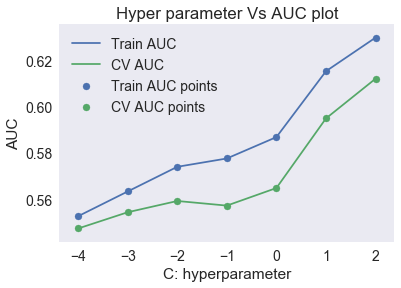

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.600564,0.041675,0.547372,0.552676,0.0001,{'C': 0.0001},7,0.547288,0.552690,0.549846,0.553273,0.544982,0.552064,0.694642,5.893669e-02,0.001987,0.000494
1,0.125015,0.010417,0.554383,0.563351,0.001,{'C': 0.001},6,0.555061,0.564473,0.554687,0.564686,0.553401,0.560894,0.012752,7.366258e-03,0.000711,0.001740
2,0.223976,0.015626,0.559236,0.573988,0.01,{'C': 0.01},4,0.558074,0.575475,0.557877,0.574712,0.561758,0.571777,0.007367,3.893359e-07,0.001785,0.001594
3,0.422113,0.010547,0.557241,0.577584,0.1,{'C': 0.1},5,0.556385,0.578523,0.554478,0.578824,0.560861,0.575405,0.014550,3.591923e-03,0.002675,0.001545
4,0.863994,0.013085,0.564837,0.586808,1,{'C': 1},3,0.564568,0.586937,0.561573,0.588171,0.568370,0.585315,0.021329,3.591642e-03,0.002781,0.001170


In [378]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint as sp_randint

lr=LogisticRegression(class_weight='balanced')
C=[0.0001,0.001,0.01,0.1,1,10,100]
params = {'C':[0.0001,0.001,0.01,0.1,1,10,100]}
clf = GridSearchCV(lr,param_grid = params, cv = 3,  scoring='roc_auc')
clf.fit(x_tr5, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_C'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
C_values =  results['param_C']

plt.plot(np.log10(C), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log10(C), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(np.log10(C), train_auc, label='Train AUC points')
plt.scatter(np.log10(C), cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results.head()

In [379]:
def batch_predict(clf, data):    
    y_data_pred = []    
    tr_loop = data.shape[0] - data.shape[0]%1000
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
                                                                
    return y_data_pred                       


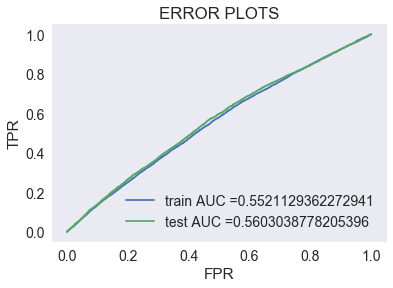

In [380]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression

best_C=0.0001
lr = LogisticRegression(penalty = 'l2', C = best_C, random_state = 0,class_weight='balanced')
lr.fit(x_tr5, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(lr, x_tr5)    
y_test_pred = batch_predict(lr, x_te5)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [381]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [382]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

Train confusion matrix
[[ 4241  3185]
 [20589 21026]]
the maximum value of tpr*(1-fpr) 0.29218224242013774 for threshold 0.499
Test confusion matrix
[[ 2933  2526]
 [13375 17218]]


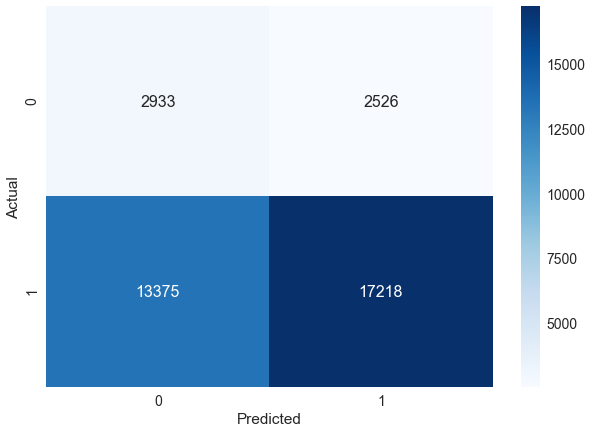

In [383]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
data = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16},fmt='g')# font size

In [385]:
from prettytable import PrettyTable as pt
x=pt()
x.field_names = ["Vectorizer", "Model", "Hyper Parameter=C", "TestAUC"]
x.add_row(["BOW","Brute",0.0001,0.52])
x.add_row(["TFIDF","Brute",0.0001,0.52])
x.add_row(["W2V","Brute",0.0001,0.52])
x.add_row(["TFIDFW2V","Brute",0.0001,0.52])
x.add_row(["Normsent","Brute",0.0001,0.56])

print(x)

+------------+-------+-------------------+---------+
| Vectorizer | Model | Hyper Parameter=C | TestAUC |
+------------+-------+-------------------+---------+
|    BOW     | Brute |       0.0001      |   0.52  |
|   TFIDF    | Brute |       0.0001      |   0.52  |
|    W2V     | Brute |       0.0001      |   0.52  |
|  TFIDFW2V  | Brute |       0.0001      |   0.52  |
|  Normsent  | Brute |       0.0001      |   0.56  |
+------------+-------+-------------------+---------+
